In [16]:
import re
import string
import numpy
import pandas as pd
import random
import math 
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import log_loss

frequency = {}
document_text = open('abstracts.txt', 'r', encoding="utf8")
text_string = document_text.read().lower()
match_pattern = re.findall(r'\b[a-z]{3,15}\b', text_string)
 
for word in match_pattern:
    count = frequency.get(word,0)
    frequency[word] = count + 1


for i in list(frequency.keys()):
    if frequency[i] == 1 or frequency[i] > 30000:
        del frequency[i]
    
orderedVocabulary = sorted(frequency.items(), key = lambda kv:(kv[1], kv[0]))

finalVocabulary = []


for pair in orderedVocabulary:
    finalVocabulary.append(pair[0])

with open('vocabulary.txt', 'w') as f:
    for word in finalVocabulary:
        f.write(word)
        f.write('\n')



In [17]:

document_text = open('abstracts.txt', 'r', encoding="utf8")
text_string = document_text.read().lower()
abstracts = re.findall("([0-9]+)\|--\|(.*)", text_string)


In [18]:
def concurrentOcc(s0, s1, splitter):
    s0List = s0.split(splitter)
    s1List = s1.split(splitter)
    if splitter == " ":
        return len(list((set(s0List) & set(finalVocabulary)) & (set(s1List) & set(finalVocabulary))))
    elif splitter == ",":
        return len(list(set(s0List) & set(s1List)))


In [19]:
document_text = open('authors.txt', 'r', encoding="utf8")
text_string = document_text.read().lower()
authors = re.findall("([0-9]+)\|--\|(.*)", text_string)



In [20]:
document_text = open('edgelist.txt', 'r', encoding="utf8")
text_string = document_text.read()
edgelist = re.findall("([0-9]+),([0-9]+)", text_string)



In [21]:
def findDegree():
    count= {}
    i=0
    while i<=138498:
        count[str(i)] = 0
        i+=1  
    for pair in edgelist:
        count[pair[0]] += 1 
        count[pair[1]] += 1 
    return count

edgeDegree = findDegree()
print("Degrees found")

edgecount0 = []
edgecount1 = []
commonWords = []
commonAuthors = []
answers = []

# Random 1000 or so pairs

j = 1
negativeRecord = None
randSelectedPair = None
while j <= 1000:
    randSelectedPair = random.randint(0, len(edgelist))
    # Appending a positive record
    pair = edgelist[randSelectedPair]
    edgecount0.append(edgeDegree[pair[0]])
    edgecount1.append(edgeDegree[pair[1]])
    commonWords.append(concurrentOcc(abstracts[int(pair[0])][1], abstracts[int(pair[1])][1], " "))
    commonAuthors.append(concurrentOcc(authors[int(pair[0])][1], authors[int(pair[1])][1], ","))
    answers.append(1)
    # Appending a (possibly) negative record
    negativeRecord = int(pair[0]) + 1281
    if negativeRecord > (len(edgeDegree)-1):
        negativeRecord -= int(pair[0]) - 281
    edgecount0.append(edgeDegree[pair[0]])
    edgecount1.append(edgeDegree[str(negativeRecord)])
    commonWords.append(concurrentOcc(abstracts[int(pair[0])][1], abstracts[negativeRecord][1], " "))
    commonAuthors.append(concurrentOcc(authors[int(pair[0])][1], authors[negativeRecord][1], ","))
    answers.append(0)
    j+=1


# First 1000 or so pairs
"""
for pair in edgelist[0:1000]:
    edgecount0.append(edgeDegree[pair[0]])
    edgecount1.append(edgeDegree[pair[1]])
    commonWords.append(concurrentOcc(abstracts[int(pair[0])][1], abstracts[int(pair[1])][1], " "))
    commonAuthors.append(concurrentOcc(authors[int(pair[0])][1], authors[int(pair[1])][1], ","))
"""

df=pd.DataFrame()
#df.columns=['edge_count_0', 'edge_count_1', 'common_words', 'common_authors']
df["edge_count_0"] = edgecount0
df["edge_count_1"] = edgecount1
df["common_words"] = commonWords
df["common_authors"] = commonAuthors
df["answers"] = answers
df.head()

Degrees found


,edge_count_0,edge_count_1,common_words,common_authors,answers
0,237,5,4,0,1
1,237,17,1,0,0
2,7,2,22,0,1
3,7,2,2,0,0
4,31,33,2,0,1


In [22]:
# Define our split-percentages
train = 0.6;
validation = 0.2;
test = 0.2;

In [23]:
# Number of instances
numberOfData = len(df);

# Number of train-validation-test instances
trainData = math.floor(numberOfData * train);
validationData = math.floor(numberOfData * validation);
testData = math.floor(numberOfData * test);

In [24]:
trainDataset = df[0:trainData];
validationDataset = df[trainData:(trainData + validationData)];
testDataset = df[(trainData + validationData):numberOfData];

In [25]:
X_train = trainDataset.drop('answers', 1);
y_train = trainDataset.answers;

X_validation = validationDataset.drop('answers', 1);
y_validation = validationDataset.answers;

X_test = testDataset.drop('answers', 1);
y_test = testDataset.answers;

C:\Users\dvlan\AppData\Local\Temp/ipykernel_3080/84815015.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = trainDataset.drop('answers', 1);
C:\Users\dvlan\AppData\Local\Temp/ipykernel_3080/84815015.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_validation = validationDataset.drop('answers', 1);
C:\Users\dvlan\AppData\Local\Temp/ipykernel_3080/84815015.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test = testDataset.drop('answers', 1);


In [26]:
# Log loss works as a mapper, so we need a base model and logistic regression is a good idea.
lr_model = LogisticRegression(solver='lbfgs');
# The error is occuring because we only have positive train date (prefferably we need a 50/50 analogy)
lr_model.fit(X_train, y_train);

In [34]:
y_pred = lr_model.predict(X_validation)
a = pd.DataFrame({'Actual value': y_validation, 'Predicted value':y_pred})
a.head()


400
400


              precision    recall  f1-score   support

           0       0.74      0.73      0.74       200
           1       0.74      0.74      0.74       200

    accuracy                           0.74       400
   macro avg       0.74      0.74      0.74       400
weighted avg       0.74      0.74      0.74       400



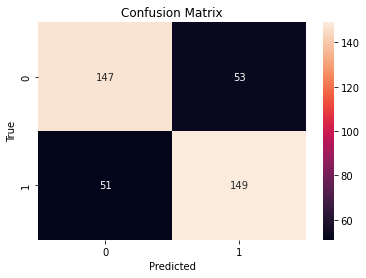

In [37]:
predicted=numpy.array(y_pred)
actual=y_validation.to_numpy()

import seaborn as sns
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix
matrix = confusion_matrix(actual, predicted)
sns.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
print(classification_report(actual, predicted))

In [28]:

logloss = log_loss(y_validation, lr_model.predict_proba(X_validation))
logloss

0.5295964232737428

In [29]:
# Now or the real test data
document_text = open('test.txt', 'r', encoding="utf8")
text_string = document_text.read()
testlist = re.findall("([0-9]+),([0-9]+)", text_string)

edgecount0 = []
edgecount1 = []
commonWords = []
commonAuthors = []


for pair in testlist:
    edgecount0.append(edgeDegree[pair[0]])
    edgecount1.append(edgeDegree[pair[1]])
    commonWords.append(concurrentOcc(abstracts[int(pair[0])][1], abstracts[int(pair[1])][1], " "))
    commonAuthors.append(concurrentOcc(authors[int(pair[0])][1], authors[int(pair[1])][1], ","))



df=pd.DataFrame()
#df.columns=['edge_count_0', 'edge_count_1', 'common_words', 'common_authors']
df["edge_count_0"] = edgecount0
df["edge_count_1"] = edgecount1
df["common_words"] = commonWords
df["common_authors"] = commonAuthors
df.head()

,edge_count_0,edge_count_1,common_words,common_authors
0,62,31,6,0
1,7,18,0,0
2,16,256,2,0
3,72,5,0,0
4,28,9,1,0


In [30]:
y_pred = lr_model.predict_proba(df)
y_pred = y_pred[:,1]


submissionFrame = pd.DataFrame();
submissionFrame["id"] = range(len(y_pred))
submissionFrame["predicted"] = y_pred
submissionFrame.to_csv('submissionFile.csv', index = False)